# Wczytywanie danych medycznych
Opracowanie: A.Florkowska

In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import Image

# Co to jest DICOM?
DICOM to standardowy format używany do zapisywania, przechowywania, czy przesyłania medycznych danych obrazowych, takich jak MRI czy CT. 

Standard DICOM definiuje sposób kodowania danych obrazowych i metadanych (informacje o pacjencie protkoły badania, informacje o urządzeniu etc). Zapewnia to na zachowanie spójności zapisu, przy jednoczesnym użytkowaniu sprzętu od różnych dostawców.

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: "['ORIGINAL', 'PRIMARY', 'AXIAL']"
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: 0aef8620785f
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice Thickness                     DS: '1.25'
(0018, 0060) KVP                                 DS: '120.0'
(0018, 1120) Gantry/Detector Tilt                DS: '0.0'
(0018, 1130) Table Height                        DS: '172.5'
(0018, 1140) Rotation Direction                  CS: 'CW'
(0018, 1151) X-Ray Tube Current                  IS: '747'
(0018, 1152) Exposure                            IS: '6'
(0018, 1210) Convolution Kernel                  SH: 'STANDARD

C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '80e30f500244'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '0aef8620785f'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '00268ff88746'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '75d23269adbd'. Please see <https:/

Text(0.5, 1.0, 'CT')

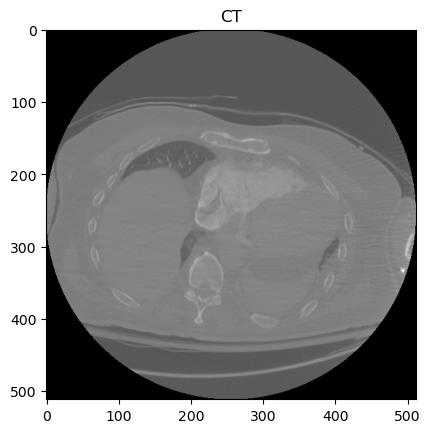

In [2]:
imageCT = pydicom.read_file(".././images/example2.dcm")
print(imageCT)

plt.imshow(imageCT.pixel_array, cmap='gray')
plt.title("CT")

# Tomografia komputerowa

# Skala Hounsfielda

Podczas pracy z danymi z tomografii komputerowej (CT) kluczowe znaczenie ma odpowiednie zrozumienie tego co one prezentują. Tomografia komputerowa to metoda diagnostyczna wykorzystujące promieniowanie rentgenowskie w celu uzyskania wielowarstkowych, przekrojowych obrazów ciała. Z kolei, promieniowanie rentgenowskie (inaczej X) to rodzaj promieniowania elektromagnetycznego, które jest generowane podczas wyhamowywania elektronów.

Promieniowanie rentgenowskie przechodzi przez ciało pacjenta, a różne tkanki absorbują różne ilości promieniowania, co pozwala na uzyskanie obrazów strukturalnych, takich jak kości i tkanki miękkie. W efekcie, dane z CT przedstawiają gęstość radiologiczną, wyrażona w jednostkach skali Hounsfielda (HU). Skala jednostek Hounsfielda jest liniowym przekształceniem pierwotnego pomiaru liniowego współczynnika osłabienia, w której gęstość radiologiczna wody destylowanej w standardowej temperaturze i ciśnieniu (warunki standardowe) jest definiowana jako 0 HU, natomiast gęstość powietrza w warunkach standardowych jest określana jako -1000 HU.

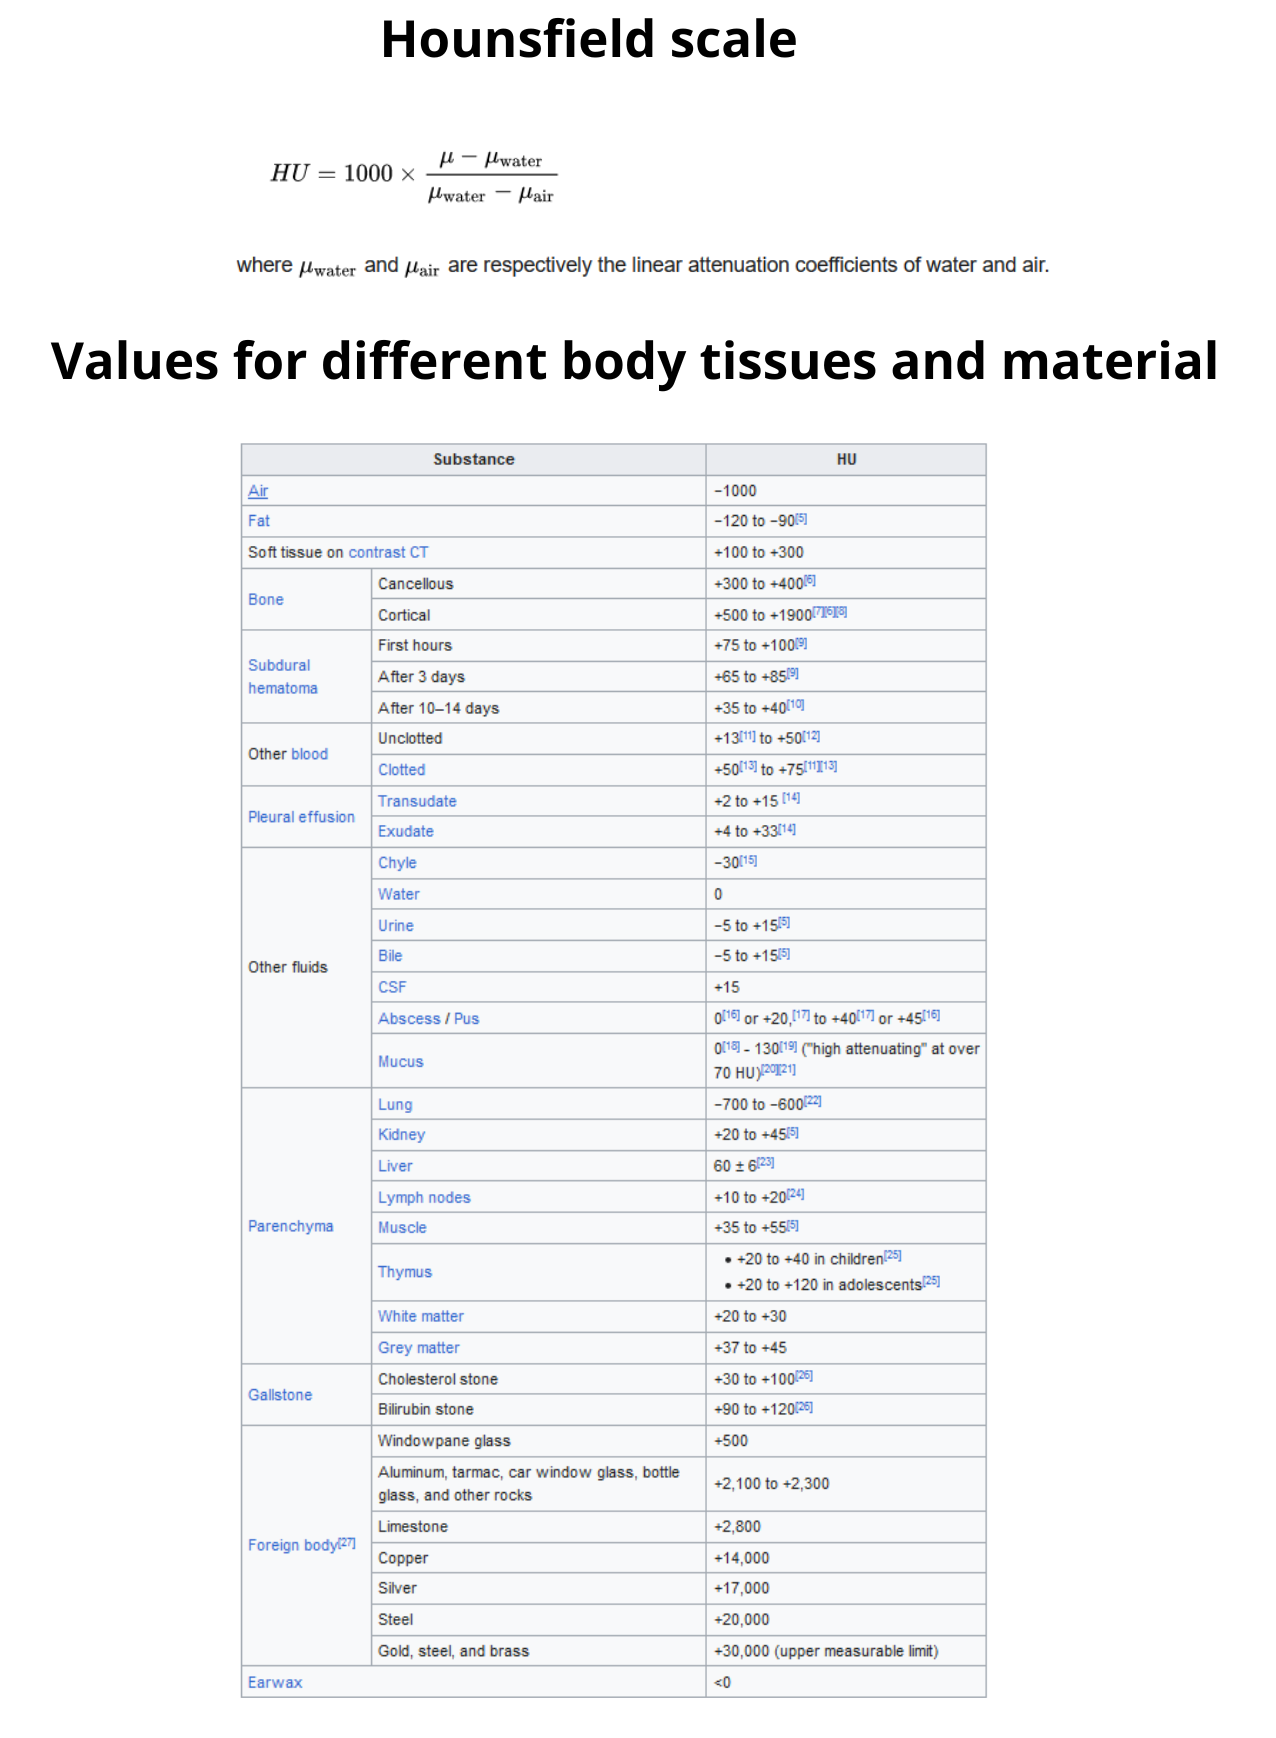

In [6]:
Image(filename=".././images/9_1.png", width=800)
# Source: https://en.wikipedia.org/wiki/Hounsfield_scale

Text(0.5, 1.0, 'Histogram')

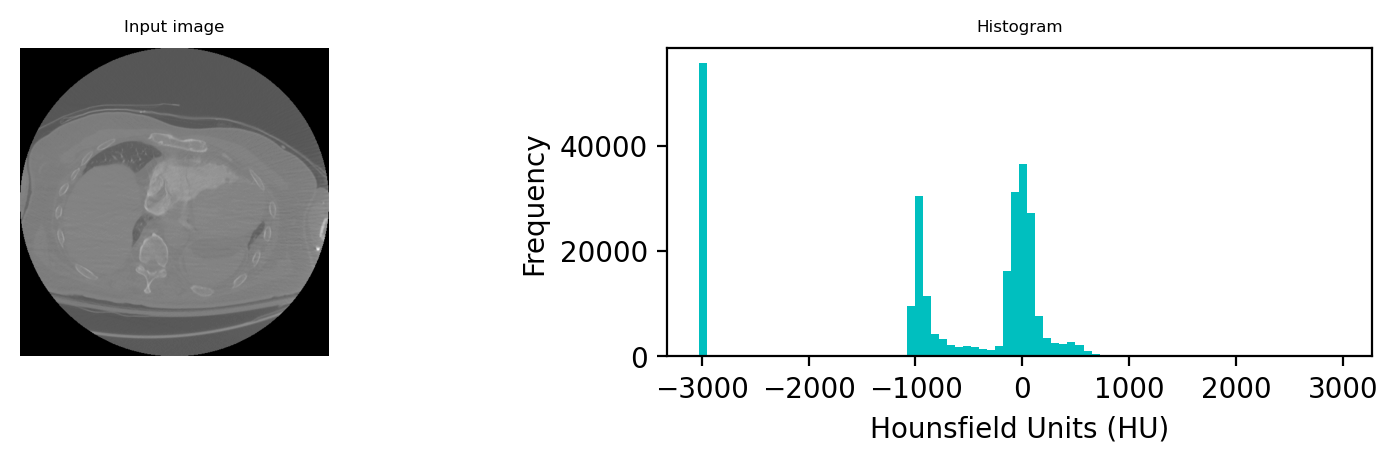

In [5]:
image = (imageCT.pixel_array).astype(np.int16)
image  = image.astype(float) * imageCT.RescaleSlope 
image = image.astype(np.int16) + np.int16(imageCT.RescaleIntercept)

plt.figure(figsize=(10, 2), dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(imageCT.pixel_array, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(1, 2, 2)
plt.hist(image.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.title("Histogram", fontsize=6)

# def apply_ct_window(img, window):
#     # window = (window width, window level)
#     R = (img-window[1]+0.5*window[0])/window[0]
#     R[R<0] = 0
#     R[R>1] = 1
#     return R
# display_img = apply_ct_window(image, [400,50])
# plt.imshow(display_img, cmap='gray')

# Resampling - ponowne próbkowanie

Dane zapisane w formacie DICOM zawierają wiele metadanych m.in. informacje o grubości piksela (slice thickness) oraz odległości między kolejnymi pikselami (pixel spacing). W praktyce może się zdarzyć, że wartości tych tagów są zależne od skanów, co może negatywnie wpłynać na wydajność np. podczas analizy przy użyciu konwolucyjnych sieci neuronowych. Na szczęście można temu zaradzić, poprzez ponownie próbkowanie, zazwyczaj do rozmiarów 1 mm x 1mm x 1mm.

In [9]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


# Normalizacja

# Centralizacja do 0

# Źródła
- Pełny tutorial: https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained, https://www.kaggle.com/code/joncarlisle/full-preprocessing-tutorial